## 根据李航《统计学习方法》中的SMO算法思路实现

建立数据集

In [90]:
import numpy as np
import matplotlib.pyplot as plt

In [91]:
X=np.array([
            [0,6],
            [1,5],
            [1,7],
            [3,3],
            [4,3],
            [3,1]])
y=np.array([1,1,1,-1,-1,-1])

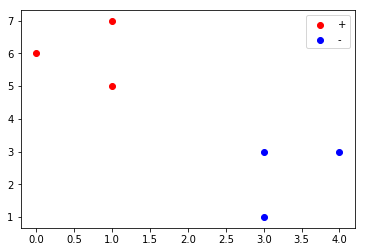

In [92]:
plt.scatter(X[y==1,0],X[y==1,1],label='+',color='r')
plt.scatter(X[y==-1,0],X[y==-1,1],label='-',color='b')
plt.legend()

涉及到的公式和流程
1.初始化alpha,E,C,b
2.根据kkt条件选取优化变量
$$
\begin{cases}
\alpha_i=0&y_ig(x_i)\geqslant1 &对应自由变量，对确定分类超平面不起作用\\
0<\alpha_i<C&y_ig(x_i)=1& 支撑向量\\
\alpha_i=C&y_ig(x_i)\leqslant1&违反了不等式约束，进行了惩罚
\end{cases}$$

In [93]:
class SVM:
    def __init__(self,kernel='linear',max_iter=2000):
        self.max_iter = max_iter
        self._kernel = kernel
    
    def _calE(self,i):
        return self._u(i)-self.y[i]
    
    def _u(self,i):
        return np.sum(self.X.dot(self.X[i])*self.alpha*self.y)+self.b
    
    def _KKT(self,i):
        yu = self._u(i)*self.y[i]
        if np.abs(self.alpha[i] - 0) <= self.epsilon:
            return yu >= 1+self.epsilon
        elif 0<self.alpha[i]<self.C:
            return np.abs(yu - 1) <= self.epsilon
        else:
            return yu <= 1-self.epsilon

    def kernel(self,i,j):
        if self._kernel == 'linear':
            return self.X[i].dot(self.X[j])
    
    def _new_alpha(self,i,j):
        if self.y[i]== self.y[j]:
            L = max(0,self.alpha[i]+self.alpha[j]-self.C)
            H = min(self.C,self.alpha[i]+self.alpha[j])
        else:
            L = max(0,self.alpha[j]-self.alpha[i])
            H = min(self.C,self.C+self.alpha[j]-self.alpha[i])
        
        eta = self.kernel(i,i)+self.kernel(j,j)-2*self.kernel(i,j)
        if eta==0:
            print("bug",i,j)
        alpha_2_un = self.alpha[j]+self.y[j]*(self.E[i]-self.E[j])/eta
        
        if alpha_2_un > H:
            alpha_2_new = H
        elif alpha_2_un < L:
            alpha_2_new = L
        else:
            alpha_2_new = alpha_2_un
        
        alpha_1_new=self.alpha[i]+self.y[i]*self.y[j]*(self.alpha[j]-alpha_2_new)
        
        return alpha_1_new,alpha_2_new
        
        
    
    def fit(self,features,labels,C=1,epsilon=1e-3):
        
        self.X = features
        self.y = labels
        self.b = 0
        self.C = C
        self.alpha = np.zeros(len(self.X))
        self.epsilon=epsilon
        self.E = np.array([self._calE(k) for k in range(len(self.X))])
        self.w = 0
        
        for internum in range(self.max_iter):
            
            index_list = np.array(np.where(self.alpha > self.epsilon)).flatten()
            non_list = np.array(np.where(abs(self.alpha) <= self.epsilon)).flatten().copy()
            all_list = np.hstack([index_list,non_list])
            
            for k in all_list:
                if self._KKT(k):
                    continue
                
                j_index = index_list[index_list!=k]
                j_non = non_list[non_list!=k]
                if(len(j_index))>1:
                    E_temp=np.abs(self.E[j_index]-self.E[k])
                    j=j_index[np.argmax(E_temp)]
                    i=k
                    break
                else:
                    E_temp=np.abs(self.E[j_non]-self.E[k])
                    j=j_non[np.argmax(E_temp)]
                    i=k
                    break
            
            
            alpha_1_new,alpha_2_new=self._new_alpha(i,j)
            
            b1_new = -self.E[i]-self.y[i]*self.kernel(i,i)*(alpha_1_new-self.alpha[i])-self.y[j]*self.kernel(j,i)*(alpha_2_new-self.alpha[j])+self.b
            b2_new = -self.E[j]-self.y[i]*self.kernel(i,j)*(alpha_1_new-self.alpha[i])-self.y[j]*self.kernel(j,j)*(alpha_2_new-self.alpha[j])+self.b
        
            if 0 < alpha_1_new <self.C:
                b_new = b1_new
            elif 0 < alpha_2_new <self.C:
                b_new = b2_new
            else:
                b_new = (b1_new+b2_new)/2
        
            self.alpha[i]=alpha_1_new
            self.alpha[j]=alpha_2_new
            self.b = b_new
            
            for k in range(len(self.X)):
                self.E[k]=self._calE(k)
 
        self.w = self._weight()
    def _weight(self):
        return np.sum(self.X*np.tile(self.y.reshape(-1,1),(1,self.X.shape[1]))*np.tile(self.alpha.reshape(-1,1),(1,self.X.shape[1])),axis=0)
       

In [94]:
clf = SVM()
clf.fit(X,y,C=100)
clf.alpha
w3 = clf.w
b3 = clf.b
clf.alpha

array([0.        , 0.14814815, 0.        , 0.14814815, 0.        ,
       0.        ])

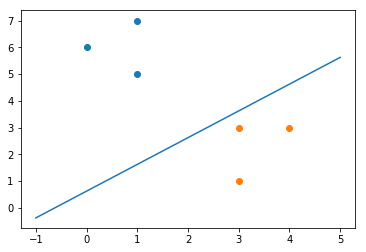

In [95]:
x_plot=np.linspace(-1,5,10000)
y_plot=(-b3-w3[0]*x_plot)/w3[1]

plt.scatter(X[y==1,0],X[y==1,1])
plt.scatter(X[y==-1,0],X[y==-1,1])
plt.plot(x_plot,y_plot)

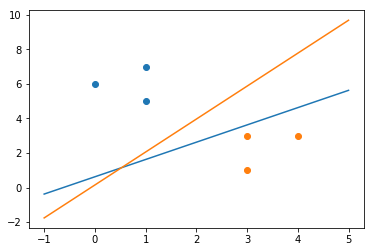

In [96]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(X,y)
w0=clf.coef_
b0=clf.intercept_
x_plot=np.linspace(-1,5,1000)
y_plot=(-b3-w3[0]*x_plot)/w3[1]
y_plot2=(-b0-w0[0,0]*x_plot)/w0[0,1]
plt.scatter(X[y==1,0],X[y==1,1])
plt.scatter(X[y==-1,0],X[y==-1,1])
plt.plot(x_plot,y_plot)
plt.plot(x_plot,y_plot2)

In [97]:
from sklearn.datasets import load_iris
iris=load_iris()
X=iris.data[iris.target!=2]
X=X[:,0:2]
y=iris.target[iris.target!=2]
y[y==0]=-1

In [98]:
clf = SVM(max_iter=1000)
clf.fit(X,y,C=1000)
clf.alpha
w = clf.w
b = clf.b
clf.alpha

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -2.22044605e-16,  0.00000000e+00,
        7.67179484e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.52991452e+01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

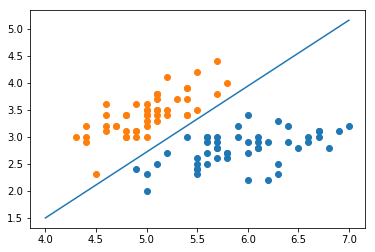

In [99]:
x_plot=np.linspace(4,7,10000)
y_plot=(-b-w[0]*x_plot)/w[1]
plt.scatter(X[y==1,0],X[y==1,1])
plt.scatter(X[y==-1,0],X[y==-1,1])
plt.plot(x_plot,y_plot)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


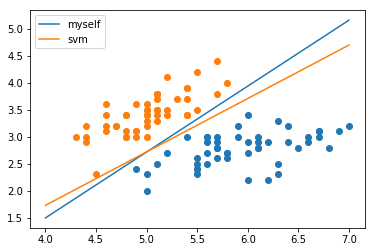

In [100]:
from sklearn.svm import LinearSVC
clf = LinearSVC(C=1000)
clf.fit(X,y)
w0=clf.coef_
b0=clf.intercept_
x_plot=np.linspace(4,7,1000)
y_plot=(-b-w[0]*x_plot)/w[1]
y_plot2=(-b0-w0[0,0]*x_plot)/w0[0,1]
plt.scatter(X[y==1,0],X[y==1,1])
plt.scatter(X[y==-1,0],X[y==-1,1])
plt.plot(x_plot,y_plot,label='myself')
plt.plot(x_plot,y_plot2,label='svm')
plt.legend()